# Exercises

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

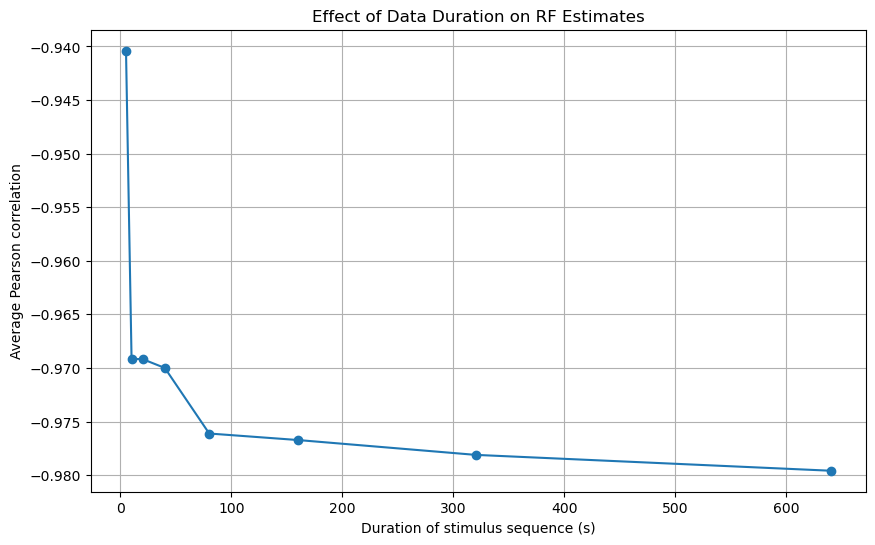

In [3]:
def generate_data_poisson(duration, true_rf, dt=0.01):
    num_samples = int(duration / dt)
    stimulus = np.random.randn(num_samples)
    lambda_t = np.exp(np.convolve(stimulus, true_rf, mode='same'))
    response = np.random.poisson(lambda_t)
    return stimulus, response

def estimate_rf_gradient_descent(stimulus, response, rf_length, learning_rate=0.01, epochs=1000):
    num_samples = len(stimulus)
    estimated_rf = np.zeros(rf_length)
    
    for epoch in range(epochs):
        conv_stimulus = np.array([np.roll(stimulus, i) for i in range(rf_length)]).T
        conv_stimulus = conv_stimulus[rf_length//2:-(rf_length//2)]
        current_response = response[rf_length//2:-(rf_length//2)]
        
        lambda_t = np.exp(conv_stimulus.dot(estimated_rf))
        
        gradient = conv_stimulus.T.dot(current_response - lambda_t) / num_samples
        estimated_rf += learning_rate * gradient
    
    return estimated_rf

def pearson_correlation(true_rf, estimated_rf):
    numerator = np.dot(true_rf, estimated_rf)
    denominator = np.linalg.norm(true_rf) * np.linalg.norm(estimated_rf)
    return numerator / denominator


true_rf = np.array([0.5, -0.2, 0.1])  
durations = [5, 10, 20, 40, 80, 160, 320, 640]  
num_realizations = 10
rf_length = len(true_rf)

# Results
average_correlations = []

for duration in durations:
    correlations = []
    for _ in range(num_realizations):
        stimulus, response = generate_data_poisson(duration, true_rf)
        estimated_rf = estimate_rf_gradient_descent(stimulus, response, rf_length)
        correlation = pearson_correlation(true_rf, estimated_rf)
        correlations.append(correlation)
    average_correlations.append(np.mean(correlations))


plt.figure(figsize=(10, 6))
plt.plot(durations, average_correlations, marker='o')
plt.xlabel('Duration of stimulus sequence (s)')
plt.ylabel('Average Pearson correlation')
plt.title('Effect of Data Duration on RF Estimates')
plt.grid(True)
plt.show()


## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

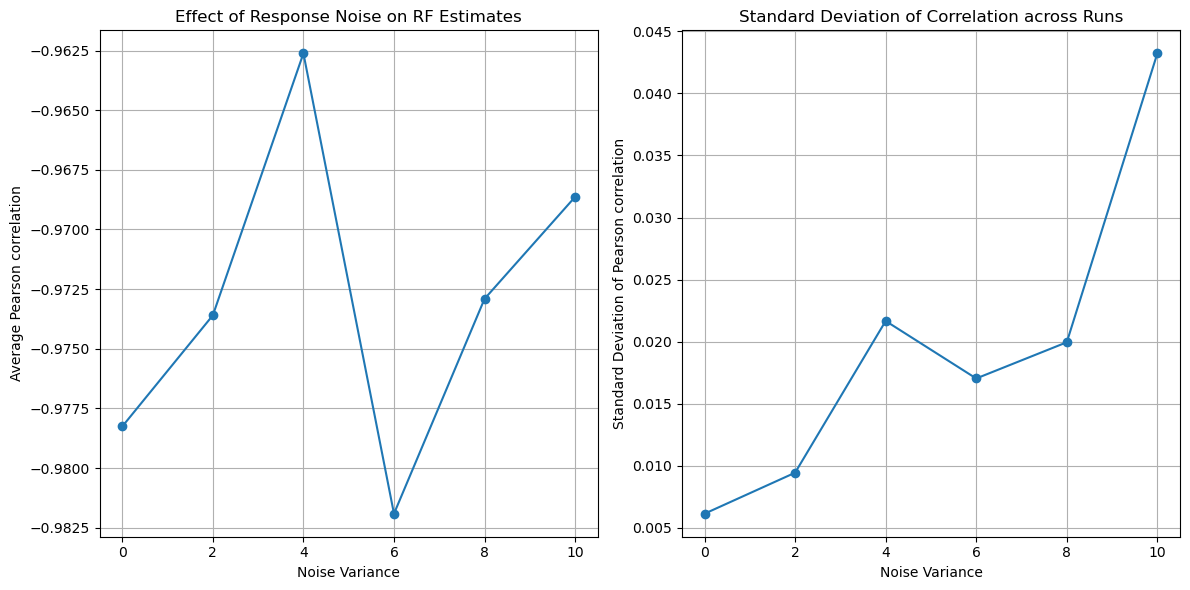

In [2]:
def generate_data_poisson_with_noise(duration, true_rf, noise_variance, dt=0.01):
    num_samples = int(duration / dt)
    stimulus = np.random.randn(num_samples)
    lambda_t = np.exp(np.convolve(stimulus, true_rf, mode='same'))
    response = np.random.poisson(lambda_t)
    noise = np.random.normal(0, np.sqrt(noise_variance), size=response.shape)
    noisy_response = response + noise
    noisy_response[noisy_response < 0] = 0  # Asegurarse de que las respuestas sean no negativas
    return stimulus, noisy_response

def estimate_rf_gradient_descent(stimulus, response, rf_length, learning_rate=0.01, epochs=1000):
    num_samples = len(stimulus)
    estimated_rf = np.zeros(rf_length)
    
    for epoch in range(epochs):
        conv_stimulus = np.array([np.roll(stimulus, i) for i in range(rf_length)]).T
        conv_stimulus = conv_stimulus[rf_length//2:-(rf_length//2)]  
        current_response = response[rf_length//2:-(rf_length//2)]
        lambda_t = np.exp(conv_stimulus.dot(estimated_rf))
        gradient = conv_stimulus.T.dot(current_response - lambda_t) / num_samples
        estimated_rf += learning_rate * gradient  
    return estimated_rf

def pearson_correlation(true_rf, estimated_rf):
    numerator = np.dot(true_rf, estimated_rf)
    denominator = np.linalg.norm(true_rf) * np.linalg.norm(estimated_rf)
    return numerator / denominator

true_rf = np.array([0.5, -0.2, 0.1])  
noise_variances = [0, 2, 4, 6, 8, 10]  
duration = 100 
num_realizations = 10
rf_length = len(true_rf)


average_correlations = []
std_correlations = []

for noise_variance in noise_variances:
    correlations = []
    for _ in range(num_realizations):
        stimulus, response = generate_data_poisson_with_noise(duration, true_rf, noise_variance)
        estimated_rf = estimate_rf_gradient_descent(stimulus, response, rf_length)
        correlation = pearson_correlation(true_rf, estimated_rf)
        correlations.append(correlation)
    average_correlations.append(np.mean(correlations))
    std_correlations.append(np.std(correlations))


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(noise_variances, average_correlations, marker='o')
plt.xlabel('Noise Variance')
plt.ylabel('Average Pearson correlation')
plt.title('Effect of Response Noise on RF Estimates')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(noise_variances, std_correlations, marker='o')
plt.xlabel('Noise Variance')
plt.ylabel('Standard Deviation of Pearson correlation')
plt.title('Standard Deviation of Correlation across Runs')
plt.grid(True)

plt.tight_layout()
plt.show()


## Exercise 3
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 




### Poisson GLM and Its Log-Likelihood

In the context of a Poisson GLM, we assume that the firing rate of a neuron is an exponential function of a linear combination of the stimulus. This can be expressed as:
$[ \lambda_t = \exp(\mathbf{s}_t \cdot \mathbf{k}) ]$
where:
- $(\lambda_t)$ is the expected firing rate at time $(t)$.
- $(\mathbf{s}_t$) is the stimulus feature vector at time $(t$).
- $(\mathbf{k}$) is the parameter vector (receptive field) that we aim to estimate.

The probability of observing $(r_t$) spikes given the stimulus $(\mathbf{s}_t$) and parameters $(\mathbf{k}$) is given by the Poisson distribution:
$[ P(r_t | \mathbf{s}_t, \mathbf{k}) = \frac{\lambda_t^{r_t} e^{-\lambda_t}}{r_t!} ]$

Due to the independence of spikes in different time intervals, the total likelihood is the product of individual probabilities:
$[ P(R | S, \mathbf{k}) = \prod_{t=1}^T P(r_t | \mathbf{s}_t, \mathbf{k}) ]$

Taking the logarithm of the likelihood converts the product into a sum:
$[ \log P(R | S, \mathbf{k}) = \sum_{t=1}^T \log P(r_t | \mathbf{s}_t, \mathbf{k}) ]$

Substituting the Poisson probability mass function, we get:
$[ \log P(R | S, \mathbf{k}) = \sum_{t=1}^T \left( r_t \log(\lambda_t) - \lambda_t - \log(r_t!) \right) ]$

Substituting $(\lambda_t = \exp(\mathbf{s}_t \cdot \mathbf{k})):
[ \log P(R | S, \mathbf{k}) = \sum_{t=1}^T \left( r_t (\mathbf{s}_t \cdot \mathbf{k}) - \exp(\mathbf{s}_t \cdot \mathbf{k}) - \log(r_t!) \right) ]$

### Relevant Terms for Maximizing the Log-Likelihood

To maximize the log-likelihood with respect to \(\mathbf{k}\), we consider the terms in the expression:
1. $( r_t (\mathbf{s}_t \cdot \mathbf{k}) )$
2. $(- \exp(\mathbf{s}_t \cdot \mathbf{k}))$
3. $(- \log(r_t!) $)

The terms that depend on $(\mathbf{k}$) are:
1. $( r_t (\mathbf{s}_t \cdot \mathbf{k}) $): This term is linear in $(\mathbf{k}$) and represents the component of the likelihood that aligns with the observed data.
2. $(- \exp(\mathbf{s}_t \cdot \mathbf{k}) $): This term introduces non-linearity and penalizes the expected firing rate exponentially.

The term $(- \log(r_t!)$) does not depend on $(\mathbf{k}$) and thus does not affect the maximization with respect to $(\mathbf{k}$). We can ignore it during the optimization process.

### Conclusion

The relevant terms for maximizing the log-likelihood with respect to $(\mathbf{k}$) are:
$[ \sum_{t=1}^T \left( r_t (\mathbf{s}_t \cdot \mathbf{k}) - \exp(\mathbf{s}_t \cdot \mathbf{k}) \right) ]$

We can simplify the log-likelihood to:
$[ \log P(R | S, \mathbf{k}) = \sum_{t=1}^T \left( r_t (\mathbf{s}_t \cdot \mathbf{k}) - \exp(\mathbf{s}_t \cdot \mathbf{k}) \right) ]$

By maximizing this function with respect to $(\mathbf{k}$), we can find the parameters that best explain the observations given the stimulus features.


## Exercise 4
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates? 

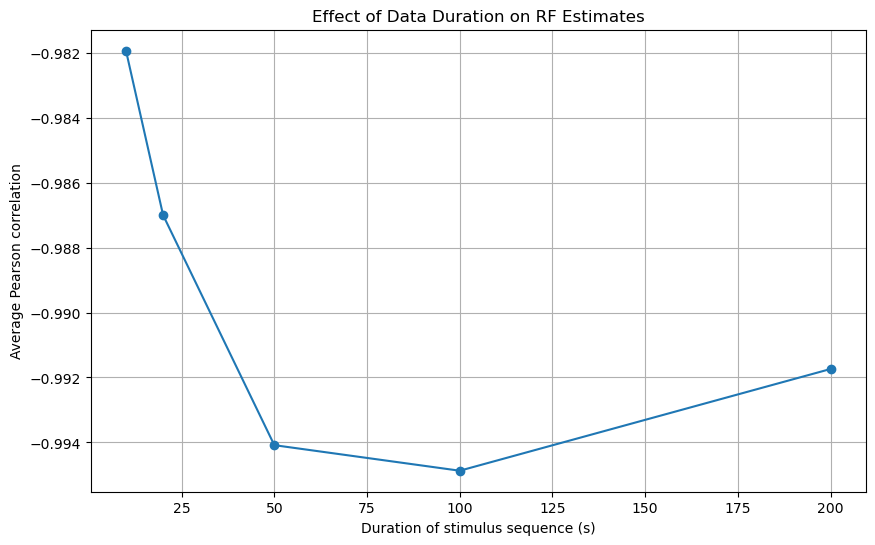

In [6]:
#A
def generate_data_poisson(duration, true_rf, dt=0.01):
    num_samples = int(duration / dt)
    stimulus = np.random.randn(num_samples)
    lambda_t = np.exp(np.convolve(stimulus, true_rf, mode='same'))
    response = np.random.poisson(lambda_t)
    return stimulus, response

def estimate_rf_gradient_descent(stimulus, response, rf_length, learning_rate=0.01, epochs=1000):
    num_samples = len(stimulus)
    estimated_rf = np.zeros(rf_length)
    
    for epoch in range(epochs):
        conv_stimulus = np.array([np.roll(stimulus, i) for i in range(rf_length)]).T
        conv_stimulus = conv_stimulus[rf_length//2:-(rf_length//2)]  # Para evitar el efecto de borde
        current_response = response[rf_length//2:-(rf_length//2)]
        lambda_t = np.exp(conv_stimulus.dot(estimated_rf))
        gradient = conv_stimulus.T.dot(current_response - lambda_t) / num_samples
        estimated_rf += learning_rate * gradient
    return estimated_rf


def pearson_correlation(true_rf, estimated_rf):
    return pearsonr(true_rf, estimated_rf)[0]


true_rf = np.array([0.5, -0.2, 0.1])  
durations = [10, 20, 50, 100, 200] 
num_realizations = 10
rf_length = len(true_rf)

# Results
average_correlations = []

for duration in durations:
    correlations = []
    for _ in range(num_realizations):
        stimulus, response = generate_data_poisson(duration, true_rf)
        estimated_rf = estimate_rf_gradient_descent(stimulus, response, rf_length)
        correlation = pearson_correlation(true_rf, estimated_rf)
        correlations.append(correlation)
    average_correlations.append(np.mean(correlations))

plt.figure(figsize=(10, 6))
plt.plot(durations, average_correlations, marker='o')
plt.xlabel('Duration of stimulus sequence (s)')
plt.ylabel('Average Pearson correlation')
plt.title('Effect of Data Duration on RF Estimates')
plt.grid(True)
plt.show()


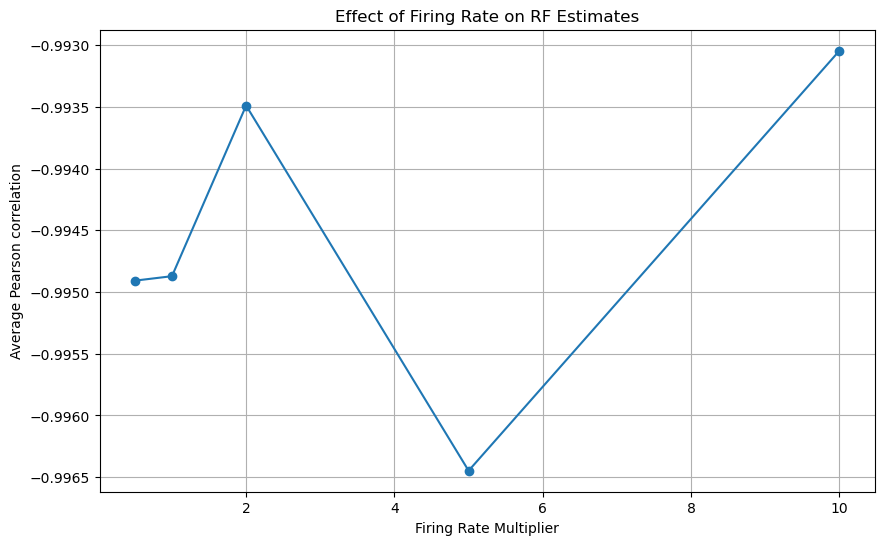

In [8]:
#B
def generate_data_poisson_firing_rate(duration, true_rf, firing_rate_multiplier, dt=0.01):
    num_samples = int(duration / dt)
    stimulus = np.random.randn(num_samples)
    lambda_t = np.exp(np.convolve(stimulus, true_rf, mode='same')) * firing_rate_multiplier
    response = np.random.poisson(lambda_t)
    return stimulus, response

firing_rate_multipliers = [0.5, 1, 2, 5, 10] 
duration = 100 
num_realizations = 10
rf_length = len(true_rf)
average_correlations = []
for firing_rate_multiplier in firing_rate_multipliers:
    correlations = []
    for _ in range(num_realizations):
        stimulus, response = generate_data_poisson_firing_rate(duration, true_rf, firing_rate_multiplier)
        estimated_rf = estimate_rf_gradient_descent(stimulus, response, rf_length)
        correlation = pearson_correlation(true_rf, estimated_rf)
        correlations.append(correlation)
    average_correlations.append(np.mean(correlations))

plt.figure(figsize=(10, 6))
plt.plot(firing_rate_multipliers, average_correlations, marker='o')
plt.xlabel('Firing Rate Multiplier')
plt.ylabel('Average Pearson correlation')
plt.title('Effect of Firing Rate on RF Estimates')
plt.grid(True)
plt.show()
